<a href="https://colab.research.google.com/github/shepai/BIORTC_Nigeria/blob/main/Workshops/rnn_gng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Recurrent Neural Networks
==================================



## Settings



In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("Python exe")
print(sys.executable)

sns.set_context("notebook")
sns.set_style("ticks")
plt.rc("axes.spines", top=False, right=False)

golden_ratio = (5**.5 - 1) / 2
width = 6
height = width * golden_ratio

matplotlib.rcParams['figure.figsize'] = [width, height]
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['lines.linewidth'] = 3

Python exe
/usr/bin/python3


## Imports



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(2)
np.random.seed(2)

## 🧠 Dynamical RNNs



Let:

-   $ x_t $: feedforward input at time step $ t $
-   $ r_t $: rate at time $ t $
-   $ y_t $: output at time $ t $

$$
r_t = (1 - \frac{\delta t}{\tau}) r_{t-1} + \frac{\Delta t}{\tau} \tanh(W_{ih} x_t + b_{ih} + W_{hh} r_{t-1})
$$

$$
y_t = \sigma(W_{ho} r_t + b_o)
$$



In [4]:
class BioRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=0.1, tau=1.0):
        super().__init__()
        # input layer
        self.wi = nn.Linear(input_size, hidden_size)
        # recurrent layer
        self.wrec = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        nn.init.xavier_uniform_(self.wrec)
        # output layer
        self.wo = nn.Linear(hidden_size, output_size)
        # non linearity
        self.nonlinearity = torch.tanh
        # time constant
        self.DT_TAU = dt / tau

    def update_dynamics(self, ff_inputs, rates):
        # updating the recurrent inputs and rates
        rec_inputs = rates @ self.wrec.T # / rates.shape[-1]
        nonlinear = self.nonlinearity(self.wi(ff_inputs) + rec_inputs)
        rates = (1-self.DT_TAU) * rates + self.DT_TAU * nonlinear

        return rates, rec_inputs


    def forward(self, ff_inputs):
        # ff_input is (n_trials, seq_len, input_size)
        # rates and rec_inputs are (n_trials, hidden_size)
        rec_inputs = torch.randn(ff_inputs.shape[0], self.wrec.shape[0])
        rates = self.nonlinearity(self.wi(ff_inputs[:, -1]) + rec_inputs)

        readout_list = []

        for step in range(ff_inputs.shape[1]):
            rates, rec_inputs = self.update_dynamics(ff_inputs[:, step], rates)
            readout = self.wo(rates)
            readout_list.append(readout)

        readout_list = torch.stack(readout_list, dim=1)

        return readout_list

---



## Initializing the model



In [5]:
input_size = 32
hidden_size = 128
output_size = 1

model = BioRNNModel(input_size, hidden_size, output_size)

## Generating a Go/NoGo task



In [6]:
DT = 0.1
stim_onset = int(1 / DT)
stim_offset = int(2 / DT)
response_onset = int(3 / DT)

seq_len = int(4 / DT)
x_time = np.linspace(0, 4, seq_len)

In [7]:
def generate_gng_trials(n_trials, seq_len, input_size, noise=0.2):
    """Generates one trial of Delayed Go/No-Go."""
    inputs = noise * torch.randn((n_trials, seq_len, input_size))
    targets = torch.zeros((n_trials, seq_len))
    mask = torch.zeros((1, seq_len))

    # Decide if it's a Go (1) or No-Go (0) trial
    is_go = torch.rand(n_trials) > 0.5
    # Apply input stimulus early in sequence
    inputs[is_go, stim_onset:stim_offset] += 1.0
    inputs[~is_go, stim_onset:stim_offset] -= 1.0
    # Output only during Go time
    targets[is_go, response_onset:] += 1.0
    targets[~is_go, response_onset:] -= 1.0

    mask[0, response_onset:] += 1.0

    return inputs, targets, mask

In [8]:
n_trials = 512
inputs, targets, mask = generate_gng_trials(n_trials, seq_len, input_size)
print(inputs.shape, targets.shape, mask.shape)

torch.Size([512, 40, 32]) torch.Size([512, 40]) torch.Size([1, 40])


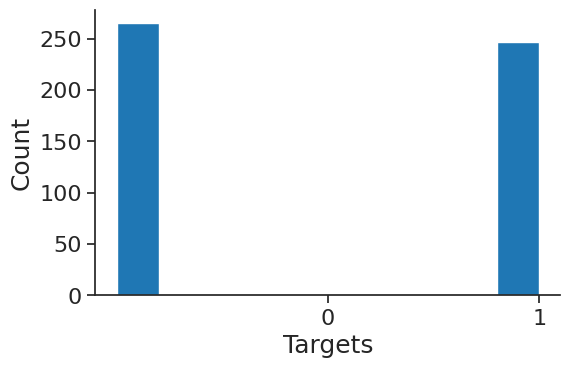

In [9]:
plt.hist(targets[..., -1].reshape(-1), bins='auto')
plt.xlabel('Targets')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()

In [10]:
idx_nogo = torch.argwhere(targets[:, -1] == -1).reshape(-1)[:32]
idx_go = torch.argwhere(targets[:, -1] == 1).reshape(-1)[:32]
print(idx_go.shape, idx_nogo.shape)

torch.Size([32]) torch.Size([32])


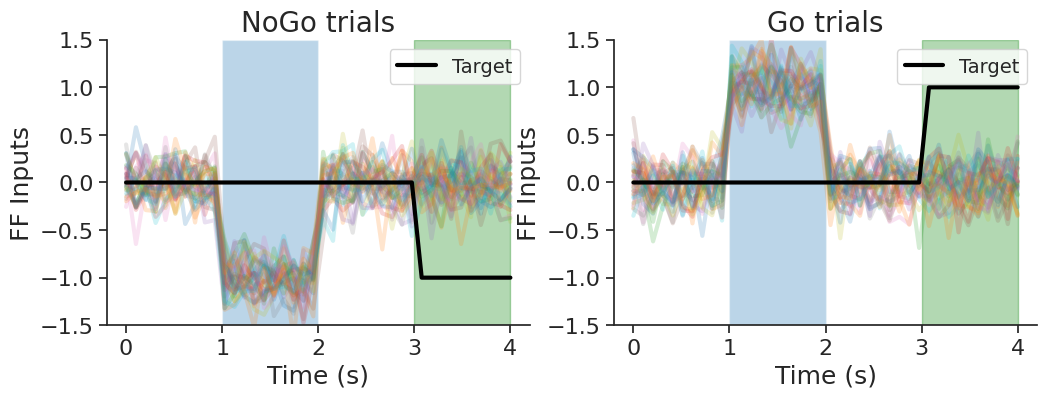

In [11]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, inputs[idx_nogo, :, 0].mT.cpu().numpy(), alpha=.2)
ax[0].plot(x_time, targets[idx_nogo[0]].cpu().numpy(), 'k', label='Target')
ax[0].set_title('NoGo trials')

ax[1].plot(x_time, inputs[idx_go, :, 0].mT.cpu().numpy(), alpha=.2)
ax[1].plot(x_time, targets[idx_go[0]].cpu().numpy(), 'k', label='Target')
ax[1].set_title('Go trials')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('FF Inputs')
    ax[i].legend(fontsize=14)
plt.show()

In [12]:
predictions = model(inputs).squeeze((0, -1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 32]) predictions torch.Size([512, 40])


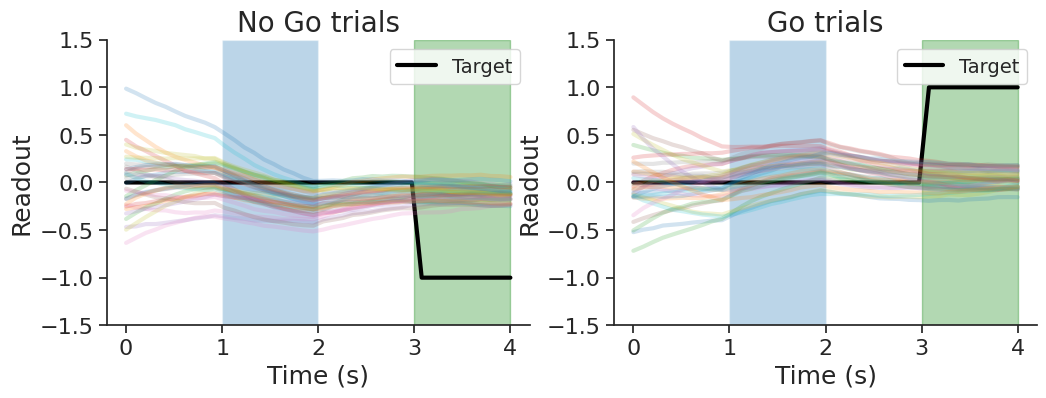

In [13]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_nogo][0], 'k', label='Target')
ax[0].plot(x_time, predictions[idx_nogo].T, alpha=.2)
ax[0].set_title('No Go trials')

ax[1].plot(x_time, targets[idx_go][0], 'k', label='Target')
ax[1].plot(x_time, predictions[idx_go].T, alpha=.2)
ax[1].set_title('Go trials')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].legend(fontsize=14)

plt.show()

## Training the model



In [14]:
learning_rate = 0.05
epochs = 50
batch_size = 32

In [15]:
def optimization(model, X, Y, criterion, optimizer, mask=1, epochs=30, batch_size=32, verbose=1):

    loss_list = []
    for epoch in range(epochs):
        permutation = torch.randperm(X.size(0))
        total_loss = 0
        for i in range(0, X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]

            output = model(batch_x).squeeze(-1)

            loss = criterion(output, batch_y) * mask
            loss += criterion(output, batch_y*0) * (1-mask)
            loss = torch.mean(loss)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        loss_list.append(total_loss)

        if (verbose) and (((epoch+1) % 5==0) or (epoch==epochs-1) or (epoch==0)):
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss:.4f}')

    return loss_list

In [16]:
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = optimization(model, inputs, targets, criterion, optimizer, mask, epochs)

Epoch 1/50, Training Loss: 0.1194
Epoch 5/50, Training Loss: 0.0192
Epoch 10/50, Training Loss: 0.0119
Epoch 15/50, Training Loss: 0.0118
Epoch 20/50, Training Loss: 0.0075
Epoch 25/50, Training Loss: 0.0080
Epoch 30/50, Training Loss: 0.0073
Epoch 35/50, Training Loss: 0.0067
Epoch 40/50, Training Loss: 0.0063
Epoch 45/50, Training Loss: 0.0046
Epoch 50/50, Training Loss: 0.0037


## Testing the model



In [17]:
inputs, targets, mask = generate_gng_trials(n_trials, seq_len, input_size)
predictions = model(inputs).squeeze((0, -1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 32]) predictions torch.Size([512, 40])


In [18]:
idx_nogo = torch.argwhere(targets[:, -1] == -1).reshape(-1)[:32]
idx_go = torch.argwhere(targets[:, -1] == 1).reshape(-1)[:32]

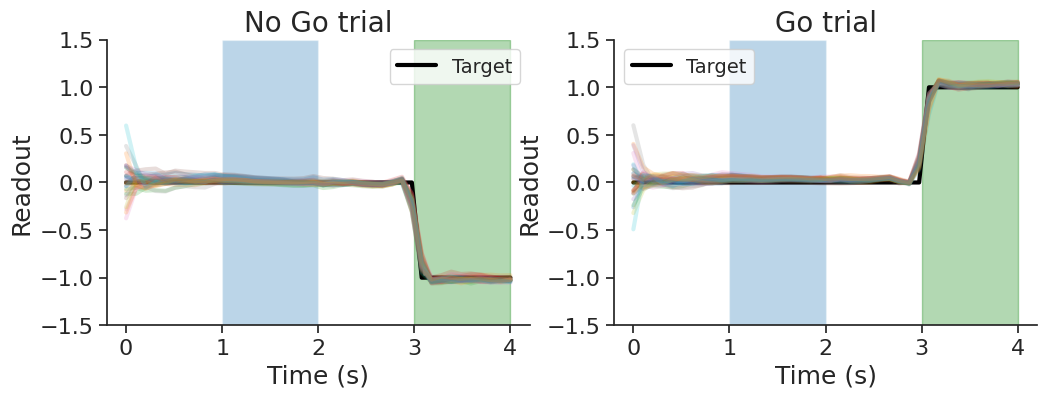

In [19]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_nogo][0], 'k', label='Target')
ax[0].plot(x_time, predictions[idx_nogo].T, alpha=.2)
ax[0].set_title('No Go trial')

ax[1].plot(x_time, targets[idx_go][0], 'k', label='Target')
ax[1].plot(x_time, predictions[idx_go].T, alpha=.2)
ax[1].set_title('Go trial')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].legend(fontsize=14)

plt.show()